<div style="width:image width px; font-size:75%; text-align:right;">
    <img src="img/kolby-milton-njOuW7E1y5g-unsplash.jpg" width="width" height="height" style="padding-bottom:0.2em;" />
    <figcaption>Foto von Kolby Milton auf Unsplash</figcaption>
</div>

# Analyse und Clustering von Rundenzeiten beim 24-Stunden-Rennen am Nürburgring 2023

**Angewandte Programmierung - SoSe 2023 - FOM - Köln**

**Sonstige Beteiligung, 2. Juni 2023**

_Patrick Haas_

## Inhalt<a class="anchor" id="toc"></a>

- [Business Understanding](#business-understanding)
  - [Forschungsfrage](#business-understanding-forschungsfrage)
  - [Datenherkunft](#business-understanding-datenursprung)
- [Data Understanding/Data Preparation](#data-understanding)
  - [Data Wrangling](#data-understanding-data-wrangling)
  - [Datenexploration](#data-understanding-data-exploration)
- [Modeling](#modeling)
- [Evaluation](#evaluation)
  - [Kritische Würdigung](#evaluation-krit)
  - [Ausblick](#evaluation-ausblick)
- [Referenzen](#referenzen)

In [1]:
import folium
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import suncalc

from sklearn import cluster, mixture

_DARK_MODE = False

## Business Understanding<a class="anchor" id="business-understanding"></a>

Am langen Wochenende vom 18.5.-21.5.2023 fand das _51. 24-Stunden-Rennen auf dem Nürburgring_ statt [[1]](#wikipedia2023a). Neben Kirmesatmosphäre rund um die Strecke konnte erstmals ein Ferrari das Rennen für sich entscheiden (und damit auch das erste Mal seit 2002 kein deutsches Fabrikat).

Rund um das Rennen kam in Berichterstattung und Interviews immer wieder die Behauptung auf, dass die anderen zum Gesamtsieg fähigen Fahrzeuge gegenüber dem Ferrari durch die _Balance of Performance (BoP)_ benachteiligt seien. Die BoP ist ein Verfahren, das für die Fahrzeuge unterschiedliche Mindestgewichte, Luftmengenbegrenzungen, Ladedruckkurven und Tankvolumina vorgibt, um alle Kandidaten trotz unterschiedlicher Fahrzeugkonzepte (Saug-/Turbomotoren, Motorplatzierung) möglichst chancengleich starten zu lassen. Sie wird vor jedem Rennen tagesaktuell durch die Rennleitung festgelegt, um die Chancengleichheit zu wahren [[2]](#adac2023a).

### Forschungsfrage<a class="anchor" id="business-understanding-forschungsfrage"></a>

Lässt sich diese Behauptung durch die erreichten Runden- und Sektorzeiten der einzelnen Fahrzeuge fundieren? Wurden die Ferrari-Fahrzeuge tatsächlich durch die BoP bevorzugt?

### Datenherkunft<a class="anchor" id="business-unterstanding-datenherkunft"></a>

Die Datenbasis ist die offizielle Zeitnahme des Rennens, die vom Veranstalter auf dem Teilnehmerportal des 24-Stunden-Rennens zur Verfügung gestellt wird [[3]](#adac2023b).


## Data Understanding/Data Preparation<a class="anchor" id="data-understanding"></a>

<div style="width:image width px; font-size:75%;">
    <img src="img/mobius_strip.png" width="50%" style="padding-bottom:0.2em;" />
    <figcaption>Darstellung via Midjourney AI</figcaption>
</div>

### Data Wrangling<a class="anchor" id="data-understanding-data-wrangling"></a>

Auf den ersten Blick wirken die Zeitnahmedaten, als ob sie aus einer über lange Zeit gewachsenen Excel-Applikation exportiert wurden. Um den Datensatz erkundbar zu machen, war an dieser Stelle jede Menge Iteration zwischen Data Understanding und Data Preparation erforderlich. 

Hier die Highlights des zeitraubenden Iterationsprozesses:

1. Die CSV-Dateien werden im ISO 8859-15-Encoding zur Verfügung gestellt. Um sowohl mit dem Editor als auch mit Python beschwerdefrei arbeiten zu können, konvertieren wir sie mit `iconv` nach UTF-8: 

```bash
for I in *.csv ; do iconv -f ISO-8859-15 -t UTF-8 -o $I.temp $I ; mv -f $I.temp $I ; done
``` 

2. Alle Rundenzeiten sind in einem Kurzformat angegeben, das grob `HH:MM:ss.SSS` entspricht. Die Behandlung von führenden Nullen ist inkonsistent und Nullwerte werden meist komplett weggelassen, was die Verwendung von Python- oder pandas-Bordmitteln zum Parsing erschwert. Wir übergeben `pd.read_csv()` daher eine Konverterfunktion, die solche Zeiten in Millisekunden umrechnet:

In [2]:
def timing_to_milliseconds(time: str) -> np.int64 | float:
    """Converts a timing string to milliseconds."""
    seconds = minutes = hours = microseconds = np.int64(0)

    match time.split("."):
        case [r, ms]:
            rest, milliseconds = r, np.int64(ms)
        case _:
            return np.nan

    match rest.split(":"):
        case [h, m, s]:
            hours = np.int64(h)
            minutes = np.int64(m)
            seconds = np.int64(s)
        case [m, s]:
            minutes = np.int64(m)
            seconds = np.int64(s)
        case [s]:
            seconds = np.int64(s)
        case _:
            return np.nan

    return hours * 3600000 + minutes * 60000 + seconds * 1000 + milliseconds


3. Einige Strings müssen von Leerzeichen befreit werden. Wir verwenden `str.strip` als Konverterfunktion

4. Die Sektordaten enthalten die Information, ob eine gegebene Sektorzeit zum entsprechenden Zeitpunkt eine Bestzeit war (`SEKTOR{n}_BESTE_ZEIT`). Diese booleschen Werte sind als 'J' und 'N' kodiert. `pd.read_csv()` bietet zwar die Möglichkeit, über `true_values` und `false_values` Zeichenketten für Wahrheitswerte zu definieren, aber das führt dazu, dass fehlende Werte in anderen Spalten falsch interpretiert werden. Wir verwenden auch hierfür eine eigene Konverterfunktion.

In [3]:
def read_sector_times_csv(_source: str | list[str]) -> pd.DataFrame:
    source = []
    if type(_source) == str:
        source = [_source]
    elif type(_source) == list:
        source = _source
    else:
        raise ValueError("Invalid source type. Must be str or list[str]")

    timing_converters = {
        feature: timing_to_milliseconds
        for feature in [
            "RUNDENZEIT",
            "THEORETISCHE_BESTZEIT",
            "DURCHGANGSZEIT",
            "SEKTOR1_ZEIT",
            "SEKTOR2_ZEIT",
            "SEKTOR3_ZEIT",
            "SEKTOR4_ZEIT",
            "SEKTOR5_ZEIT",
            "SEKTOR6_ZEIT",
            "SEKTOR7_ZEIT",
            "SEKTOR8_ZEIT",
            "SEKTOR9_ZEIT",
            "THEORETISCHE_BESTZEIT"
        ]
    }

    string_converters = {
        feature: str.strip
        for feature in ["KLASSE", "KLASSESORT", "UNTERKLASSE", "KLASSEKURZ"]
    }

    bool_converters = {
        feature: lambda x: True if x == "J" else False
        for feature in [
            "SEKTOR1_BESTE_ZEIT", 
            "SEKTOR2_BESTE_ZEIT", 
            "SEKTOR3_BESTE_ZEIT", 
            "SEKTOR4_BESTE_ZEIT", 
            "SEKTOR5_BESTE_ZEIT", 
            "SEKTOR6_BESTE_ZEIT", 
            "SEKTOR7_BESTE_ZEIT", 
            "SEKTOR8_BESTE_ZEIT", 
            "SEKTOR9_BESTE_ZEIT",
        ]
    }

    return pd.concat(
        [
            pd.read_csv(
                f,
                delimiter=";",
                # can't use true_values and false_values or 
                # some missing sector data gets parsed as boolean
                # true_values=["J"],
                # false_values=["N"],
                converters={**timing_converters, **string_converters, **bool_converters},
                dtype={"FAHRER3_ORT": str}
            )
            for f in source
        ]
    )

5. Geschmackssache, aber da wir gerade dabei sind: Die in den CSV-Dateien enthaltenen Spaltentitel sind großgeschrieben und auf Deutsch. Wir ersetzen sie durch kleingeschriebene englische Titel:

In [4]:
def rename_sector_times_columns(df: pd.DataFrame) -> pd.DataFrame:
    header_mapping = {
        "STNR": "car_number",
        "KUERZEL": "abbreviation",
        "FAHRER_NR": "driver_number",
        # generate mappings for FAHRER{N}
        "NATION": "team_nationality",
        "BEWERBER": "team",
        "TEAM": "team_category",
        "FAHRZEUG": "car",
        "RUNDE_NR": "lap_number",
        "DURCHGANGSZEIT": "elapsed_time",
        "TAGESZEIT": "time_of_day",
        "RUNDENZEIT": "lap_time",
        "RUNDENZEIT_IN_SEKUNDEN": "lap_time_seconds",
        "DIESCHNELLSTE": "is_fastest",
        "KLASSE": "class",
        "KLASSESORT": "class_sort",
        "UNTERKLASSE": "subclass",
        "KLASSEKURZ": "class_short",
        # generate mapping for SEKTOR{N}
        "TOPSPEED_KMH": "top_speed_kmh",
        "TOPSPEED_BESTE_SPEED": "top_speed_best_speed",
        "TOPSPEED_KMH2": "top_speed_kmh2",
        "TOPSPEED_BESTE_SPEED2": "top_speed_best_speed2",
        "TOPSPEED_KMH3": "top_speed_kmh3",
        "TOPSPEED_BESTE_SPEED3": "top_speed_best_speed3",
        "SEKTOR_BESTE_SUMME": "sector_best_sum",
        "RANG": "rank",
        "INPIT": "in_pit",
        "CANCELLED": "cancelled",
        "PITSTOPDURATION": "pitstop_duration",
        "BEWERBERLIZENZ": "applicant_license",
        "PITIN_TIME": "pitin_time",
        "RUNDE_NR_TEXT": "lap_number_text",
        "WET": "wet",
        "PRO": "pro",
        "PROAM": "pro_am",
        "PRIO": "priority",
        "STINT": "stint",
        "LAPINSTINT": "lap_in_stint",
        "THEORETISCHE_BESTZEIT": "theoretical_best_time",
    }

    # generate mapping for FAHRER{N}
    for i in range(9):
        a = f"FAHRER{i+1}"
        b = f"driver{i+1}"
        driver = {
            f"{a}_NAME": f"{b}_lastname",
            f"{a}_VORNAME": f"{b}_firstname",
            f"{a}_ORT": f"{b}_city",
            f"{a}_SPONSORLIZENZ": f"{b}_sponsor_license",
            f"{a}_SPONSOR": f"{b}_sponsor",
            f"{a}_LIZENZ": f"{b}_license",
            f"{a}_NATION": f"{b}_nationality",
            f"{a}_PUNKTEWERTUNG": f"{b}_points",
        }
        header_mapping = {**header_mapping, **driver}

    # generate mapping for SEKTOR{N}
    for i in range(10):
        a = f"SEKTOR{i+1}"
        b = f"sector"
        sector = {
            f"{a}_ZEIT": f"{b}time_{i+1}",
            f"{a}_BESTE_ZEIT": f"{b}is_best_time_{i+1}",
            f"{a}_KMH": f"{b}speed_kmh_{i+1}",
            f"{a}_BESTE_SPEED": f"{b}is_best_speed_{i+1}",
        }
        header_mapping = {**header_mapping, **sector}

    return df.rename(columns=header_mapping)


6. In der explorativen Datenanalyse könnten die jeweils aktiven Fahrer:innen pro Startnummer und Runde interessant sein. Alle möglichen Fahrer:innen einer Startnummer sind als `FAHRER{n}_NAME`, `FAHRER{n}_VORNAME`, usw. in jeder Zeile der Zeitnahmedaten aufgeführt. Die Spalte `FAHRER_NR` besagt, welche:r Fahrer:in gerade aktiv ist. Wir verwenden eine Funktion, um die redundanten Informationen zu entfernen und nur aktive Fahrer:innen beizubehalten:

In [5]:
def select_current_driver(df: pd.DataFrame) -> pd.DataFrame:
    newdf = pd.DataFrame(df)
    newdf["driver_name"] = newdf.apply(
        lambda x: f"{x.iloc[3 + (x['driver_number'] - 1) * 8]}, {x.iloc[4 + (x['driver_number'] - 1) * 8]}",
        axis=1,
    )

    newdf["driver_license"] = newdf.apply(
        lambda x: x.iloc[8 + (x["driver_number"] - 1) * 8], axis=1
    )
    return newdf


7. Wir entfernen alle Features, die für die weitere Analyse nicht von Belang sind:

In [6]:
def drop_unused_columns(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop(
        columns=[
            "abbreviation",
            "applicant_license",
            "cancelled",
            "class_sort",
            "class",
            "driver_license",
            "driver_number",
            "driver1_city",
            "driver1_firstname",
            "driver1_lastname",
            "driver1_license",
            "driver1_nationality",
            "driver1_points",
            "driver1_sponsor_license",
            "driver1_sponsor",
            "driver2_city",
            "driver2_firstname",
            "driver2_lastname",
            "driver2_license",
            "driver2_nationality",
            "driver2_points",
            "driver2_sponsor_license",
            "driver2_sponsor",
            "driver3_city",
            "driver3_firstname",
            "driver3_lastname",
            "driver3_license",
            "driver3_nationality",
            "driver3_points",
            "driver3_sponsor_license",
            "driver3_sponsor",
            "driver4_city",
            "driver4_firstname",
            "driver4_lastname",
            "driver4_license",
            "driver4_nationality",
            "driver4_points",
            "driver4_sponsor_license",
            "driver4_sponsor",
            "driver5_city",
            "driver5_firstname",
            "driver5_lastname",
            "driver5_license",
            "driver5_nationality",
            "driver5_points",
            "driver5_sponsor_license",
            "driver5_sponsor",
            "driver6_city",
            "driver6_firstname",
            "driver6_lastname",
            "driver6_license",
            "driver6_nationality",
            "driver6_points",
            "driver6_sponsor_license",
            "driver6_sponsor",
            "driver7_city",
            "driver7_firstname",
            "driver7_lastname",
            "driver7_license",
            "driver7_nationality",
            "driver7_points",
            "driver7_sponsor_license",
            "driver7_sponsor",
            "driver8_city",
            "driver8_firstname",
            "driver8_lastname",
            "driver8_license",
            "driver8_nationality",
            "driver8_points",
            "driver8_sponsor_license",
            "driver8_sponsor",
            "is_fastest",
            "lap_number_text",
            "lap_time_seconds",
            "pitin_time",
            "pitstop_duration",
            "priority",
            "pro",
            "pro_am",
            "rank",
            "sector_best_sum",
            "sectoris_best_time_1",
            "sectoris_best_speed_1",
            "sectorspeed_kmh_1",
            "sectoris_best_time_2",
            "sectoris_best_speed_2",
            "sectorspeed_kmh_2",
            "sectoris_best_time_3",
            "sectoris_best_speed_3",
            "sectorspeed_kmh_3",
            "sectoris_best_time_4",
            "sectoris_best_speed_4",
            "sectorspeed_kmh_4",
            "sectoris_best_time_5",
            "sectoris_best_speed_5",
            "sectorspeed_kmh_5",
            "sectoris_best_time_6",
            "sectoris_best_speed_6",
            "sectorspeed_kmh_6",
            "sectoris_best_time_7",
            "sectoris_best_speed_7",
            "sectorspeed_kmh_7",
            "sectoris_best_time_8",
            "sectoris_best_speed_8",
            "sectorspeed_kmh_8",
            "sectoris_best_time_9",
            "sectoris_best_speed_9",
            "sectorspeed_kmh_9",
            "subclass",
            "team_category",
            "team_nationality",
            "top_speed_best_speed",
            "top_speed_best_speed2",
            "top_speed_best_speed3",
            "top_speed_kmh",
            "top_speed_kmh2",
            "top_speed_kmh3",
            "wet",
        ],
    )

8. Dann definieren wir noch einen Index, um jede Zeile durch Startnummer und Rundennummer eindeutig zu identifizieren:

In [7]:
def make_lap_index(df: pd.DataFrame) -> pd.DataFrame:
    return df.set_index(["car_number", "lap_number"])

9. Abschließend setzen wir die Puzzleteile zusammen und laden die Daten in ein DataFrame:

In [8]:
def read_sector_times(_source: str | list[str]) -> pd.DataFrame:
    df = read_sector_times_csv(_source)
    df = rename_sector_times_columns(df)
    df = select_current_driver(df)
    df = drop_unused_columns(df)
    df = make_lap_index(df)
    return df

df_race_sectors  = read_sector_times([
        "data/2023/24h/race_rennen_sektorzeiten_part_1.csv",
        "data/2023/24h/race_rennen_sektorzeiten_part_2.csv",
    ])
df_race_sectors.sample(5)

,,team,car,elapsed_time,time_of_day,lap_time,class_short,sectortime_1,sectortime_2,sectortime_3,sectortime_4,sectortime_5,sectortime_6,sectortime_7,sectortime_8,sectortime_9,in_pit,stint,lap_in_stint,theoretical_best_time,driver_name
car_number,lap_number,,,,,,,,,,,,,,,,,,,,
74,38,Walkenhorst Motorsport,BMW M4 GT4 (G82),80309302,22:18:29.302,794981,SP 10,225868.0,49170.0,75546.0,12286.0,142271.0,39846.0,197248.0,20782.0,31964.0,A,6,1,537969,"Balanian, Aris"
522,25,SRS Team Sorg Rennsport,BMW 330i,73971947,20:32:51.947,637467,VT2 Heck,47984.0,52454.0,78374.0,12815.0,149366.0,44931.0,193603.0,23536.0,34404.0,N,4,2,591211,"Leukers, Christian"
123,126,Muehlner Motorsport,Porsche 911 GT3 Cup (992),134426445,13:20:26.445,523348,Cup 2,41797.0,44757.0,68118.0,10725.0,113679.0,36173.0,158402.0,20007.0,29690.0,N,18,3,510791,"Bünnagel, Ben"
71,80,Toyo Tire with Ring Racing,Toyota GR Supra GT4 EVO 2023,105207133,05:13:27.133,617620,SP 10,44019.0,47192.0,69837.0,11295.0,130859.0,38312.0,223484.0,21446.0,31176.0,N,12,2,535125,"Gülden, Andreas"
526,5,QTQ-Raceperformance,BMW 330i,60883830,16:54:43.830,598371,VT2 Heck,48471.0,51966.0,76483.0,12382.0,129609.0,43605.0,179613.0,23089.0,33153.0,N,1,5,592466,"nan, nan"



Die Daten sind jetzt in einem Zustand, in dem wir sie für die explorative Datenanalyse verwenden können.


### Datenexploration<a class="anchor" id="data-understanding-data-exploration"></a>

Wir sehen uns zuerst die Verteilung der Rundenzeiten in der gesamtsiegfähigen SP 9-Klasse an. Dazu filtern wir die Daten nach der Klasse, lassen Boxenrunden weg, gruppieren nach Fahrzeug und plotten die Rundenzeiten als Violinplot mit überlagerten Einzelwerten:

In [9]:
def plot_time_distribution(df: pd.DataFrame, value: str = "lap_time", hue: str | None = None) -> None:
    df = df.copy()
    df["__sort_q2"] = df.groupby("car")[value].transform(np.quantile, q=0.5)
    f, ax = plt.subplots(figsize=(15, 10))
    df.sort_values("__sort_q2", inplace=True)

    sns.violinplot(
        y=df["car"],
        x=df[value],
        bw=0.1,
        palette="deep",
        cut=0,
    )
    sns.stripplot(
        y=df["car"],
        x=df[value],
        jitter=0.2,
        size=2.5,
        color="red" if not hue else None,
        palette="bright" if hue else None,
        hue=df[hue] if hue else None,
    )
    sns.despine()

In [10]:
df_sp9_sectors = pd.DataFrame(df_race_sectors.query("class_short == 'SP 9'"))

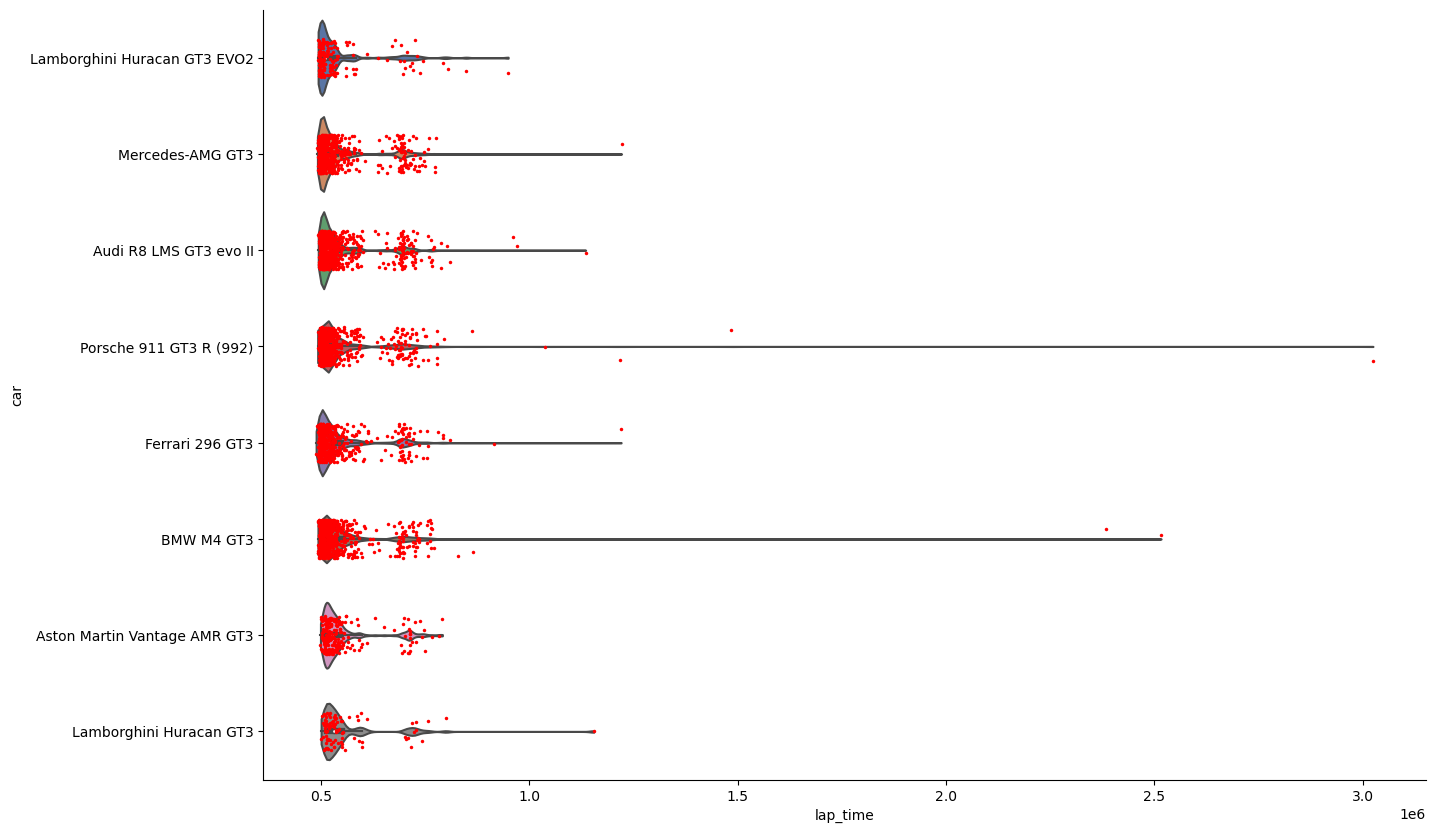

In [11]:
plot_time_distribution(df_sp9_sectors)

Erster Eindruck: Einige extreme Ausreißer sorgen dafür, dass der interessante Bereich der Verteilung schwer zu erkennen ist. Wir filtern die Daten nach Rundenzeiten unter 13 Minuten:

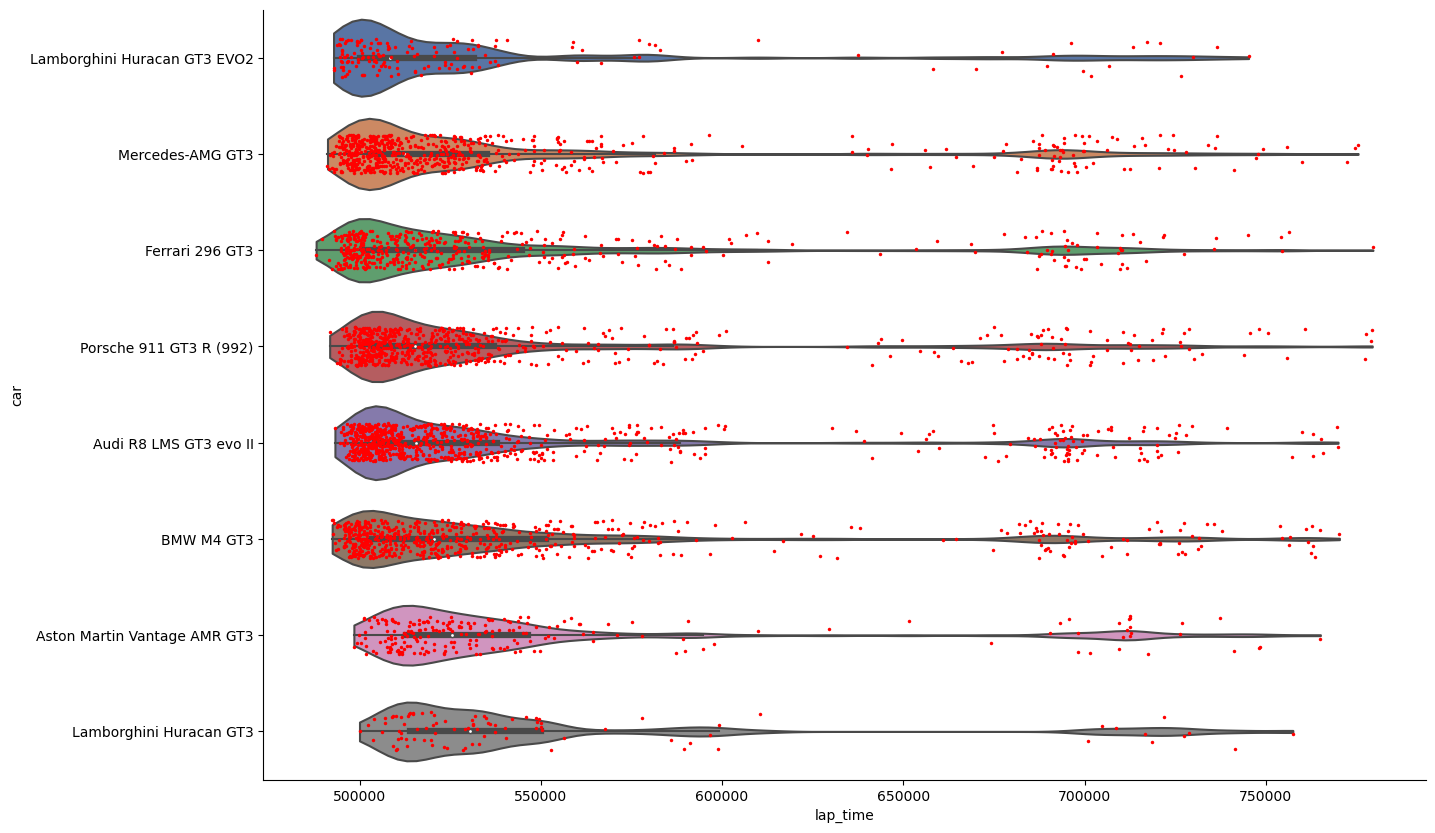

In [12]:
plot_time_distribution(df_sp9_sectors.query("lap_time < 780000"))

Auffällig ist die Q-Tip-Form. Die Rundenzeiten streuen insgesamt zwar stark, sammeln sich aber dennoch um einige Schwerpunkte.

Die Intuition aus dem Business Understanding dazu ist, dass Profifahrer:innen sehr konstante Rundenzeiten fahren können. Das bedeutet, dass die Verteilung ihrer Zeiten sich mit geringer Varianz um einen Mittelwert bewegen und nach dem zentralen Grenzwertsatz durch eine Gauß-Verteilung annäherbar sein sollte. Allerdings gilt das nur für ungestörte Runden. 

Werfen wir einen kurzen Blick auf mögliche Störgrößen:

<div style="font-size:50%;">
    <span style="width: 15%; display: inline-block;">
        <img src="img/musa-haef-traffic-unsplash.jpg" style="padding-bottom:0.2em" />
        <figcaption>Foto von Musa Haef auf Unsplash</figcaption>
    </span>
    <span style="width: 15%; display: inline-block;">
        <img src="img/Auto_Racing_Yellow.svg" style="padding-bottom:0.2em;" />
    </span>
    <span style="width: 15%; display: inline-block;">
        <img src="img/Auto_Racing_Code_60_flag.svg" style="padding-bottom:0.2em;" />
    </span>
    <span style="width: 15%; display: inline-block;">
        <img src="img/david-latorre-romero-pit-stop-unsplash.jpg" style="padding-bottom:0.2em;" />
        <figcaption>Foto von david latorre romero auf Unsplash</figcaption>
    </span>
    <span style="width: 15%; display: inline-block;">
        <img src="img/kenny-eliason-flat-tire-unsplash.jpg" style="padding-bottom:0.2em;" />
        <figcaption>Foto von Kenny Eliason auf Unsplash</figcaption>
    </span>
    <span style="width: 15%; display: inline-block;">
        <img src="img/saeed-gh-wet-road-unsplash.jpg" style="padding-bottom:0.2em;" />
        <figcaption>Foto von Saeed Gh auf Unsplash</figcaption>
    </span>

</div>

- __Verkehr__: Die Fahrer:innen müssen langsamere Fahrzeuge überholen
- __Gelbe Flagge__: Überholverbot bis zur Aufhebung. Die Fahrer:innen hängen im gegebenenfalls deutlich langsameren Verkehr fest
- __Doppelte gelbe Flagge__: Wie Gelb, zusätzlich mit Geschwindigkeitsbegrenzung auf 120 km/h
- __Code 60__: Wie Gelb, zusätzlich mit Geschwindigkeitsbegrenzung auf 60 km/h
- __Boxenstops__: Die Fahrer:innen steuern geplant zum Tanken, Reifenwechsel und Fahrerwechsel oder ungeplant zur Reparatur die Box an. Für Boxenstopps wird eine Mindeststandzeit vorgeschrieben
- __Defekt__: Die Fahrer:innen müssen in langsamer Fahrt zurück an die Box oder fallen endgültig aus
- __Streckenbedingungen__: Bei nasser Fahrbahn müssen die Fahrer:innen ihre Fahrweise deutlich anpassen
- __Kombinationen__ aus den genannten Störgrößen

__Doppeltgelbe__, __Code-60__-Bereiche und __geplante Boxenstops__ haben intuitiv einen konstanten, vergleichsweise großen Einfluss auf die Rundenzeiten aller betroffenen Fahrer. Sie verschieben Teile der Gaußverteilung mehr oder weniger stark nach rechts verschieben und sorgen für die Schwerpunkte im Stab der Q-Tips.

__Verkehr__ und __gelbe Flaggen__ sind dagegen eher zufällige Faktoren mit unsystematischem Einfluss, die sich in der Varianz der Verteilungen widerspiegeln.

Die __Streckenbedingungen__ waren während des Rennens 2023 außergewöhnlich konstant. Es wurde keine Rennrunde unter nassen Bedingungen gefahren. Tag-, Nacht- und Blendbedingungen sowie die Außentemperatur sind ebenfalls wichtige Faktoren, die allerdings alle Teilnehmer gleichermaßen betreffen.

__Defekte__ sind ein Sonderfall, da sie die Rundenzeit eines einzelnen Fahrers in der Regel dramatisch beeinflussen, aber eher seltene Ereignisse sind.

Um die Forschungsfrage zu beantworten, wollen wir Rundenzeiten, welche Störgrößen enthalten, möglichst herausfiltern. Wir gehen dazu von der Annahme aus, dass die Rundenzeitverteilung einem Gaußschen Mischmodell [[4]](#skl2023a) folgt, d.h. dass sie sich in mehrere überlagerte Gaußverteilungen zerlegen lassen. Wir sortieren die gefundenen Komponenten nach ihrem Mittelwert und nutzen das Modell anschließend zur Klassifikation der Rundenzeiten - je kleiner der Clusterindex, desto ungestörter die Rundenzeit.

<div style="width:image width px; font-size:75%;">
    <img src="img/lap_time_distribution_clusters.jpg" width="width" height="height" style="padding-bottom:0.2em;" />
    <figcaption>Grün: Ungestörte Runden. Gelb: Leichte Störung, orange: starke Störung. Rot: Boxenstops.</figcaption>
</div>

## Modeling/Feature Learning<a class="anchor" id="modeling"></a>

Um die Rundenzeiten der Fahrzeuge zu clustern und das Cluster den Daten hinzuzufügen, verwenden wir das `GaussianMixture`-Modell aus _scikit-learn_ [[5]](#skl2023b). Das Modell ist ein Unsupervised Learning-Verfahren, das mit der Anzahl der erwarteten Cluster initialisiert wird und dann die Parameter der Gaußverteilungen, die die Daten am besten beschreiben, lernt.

Runden mit Boxenstopp-Störung sind in den Daten entsprechend markiert, wir filtern sie hier heraus. Ebenso entfernen wir Runden, die mehr als 11 Minuten dauern. Diese sind in der Regel durch Defekte oder Unfälle verursacht und würden die Clusterbildung stören.

In [13]:
def gmc(df: pd.DataFrame, column: str, group_name: str) -> pd.DataFrame:
    gmc = mixture.GaussianMixture(n_components=4)
    res = pd.DataFrame(df)
    component_labels = gmc.fit_predict(res[[column]])
    component_mean_ranks = gmc.means_.flatten().argsort().argsort()
    component_ranks = np.vectorize(component_mean_ranks.take)(component_labels)
    res[f"cluster_by_{group_name}"] = component_ranks
    return res

df_sp9_sectors = df_sp9_sectors.query("in_pit == 'N' and lap_time < 660000")
df_sp9_sectors = df_sp9_sectors.groupby("car", group_keys=False).apply(gmc, "lap_time", "car_lap")

Nach dem Fitting des Modells können wir die Clusterzugehörigkeit der Runden abfragen und die Plausibilität des Clusterings anhand der Visualisierung bewerten:

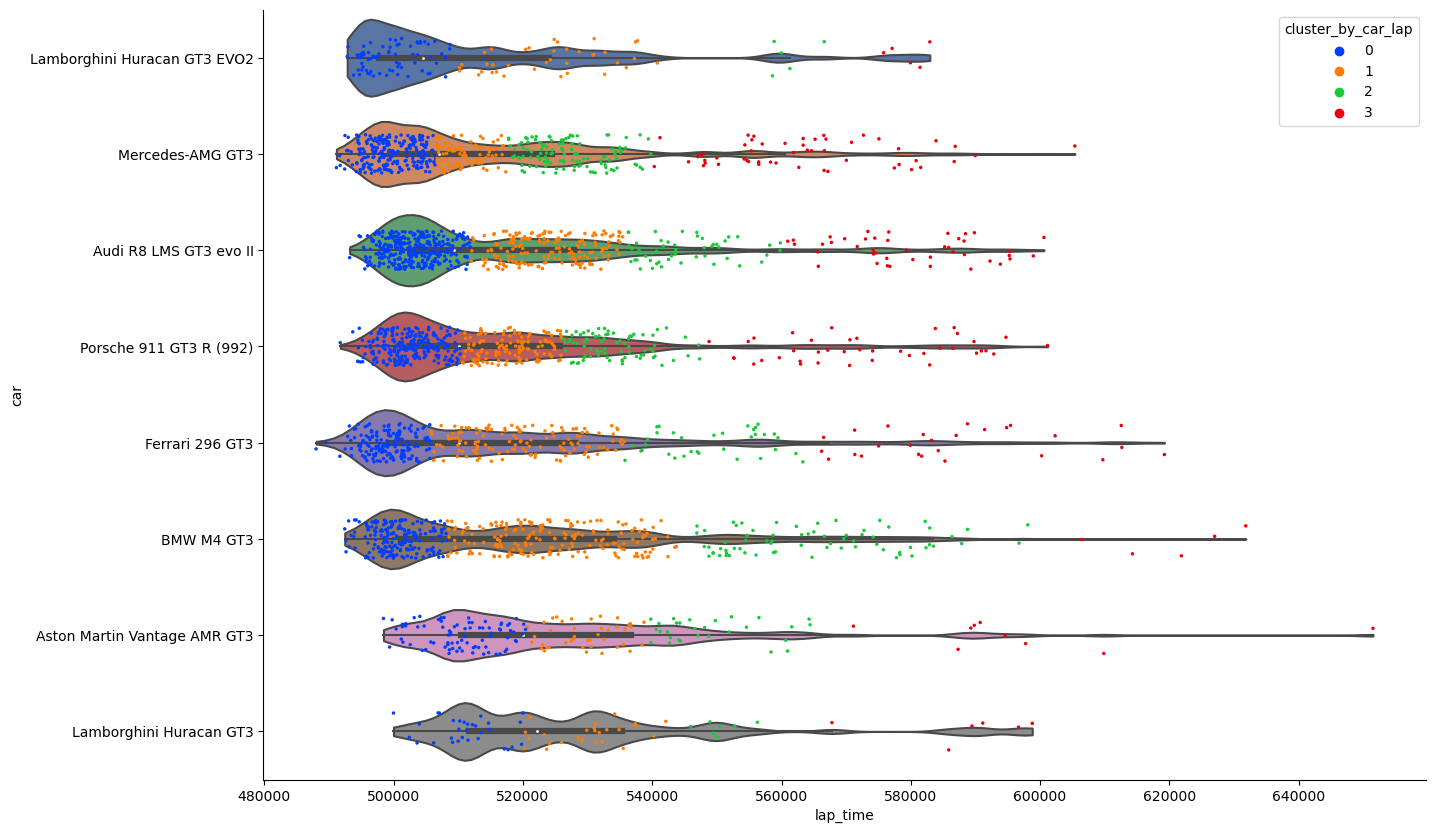

In [14]:
plot_time_distribution(df_sp9_sectors, hue="cluster_by_car_lap")

Das Modell ist insbesondere bei den Fahrzeugen, die vergleichsweise wenige Runden gefahren sind, nicht perfekt, fängt aber die Struktur der Verteilung gut ein.

## Evaluation<a class="anchor" id="evaluation"></a>

Nun können wir die Clusterinformation nutzen, um ungestörte Rundenzeiten zu selektieren und deren Verteilung für die einzelnen Fahrzeuge zu visualisieren (wir lassen die abgeschlagenen Fahrzeuge ab hier weg):

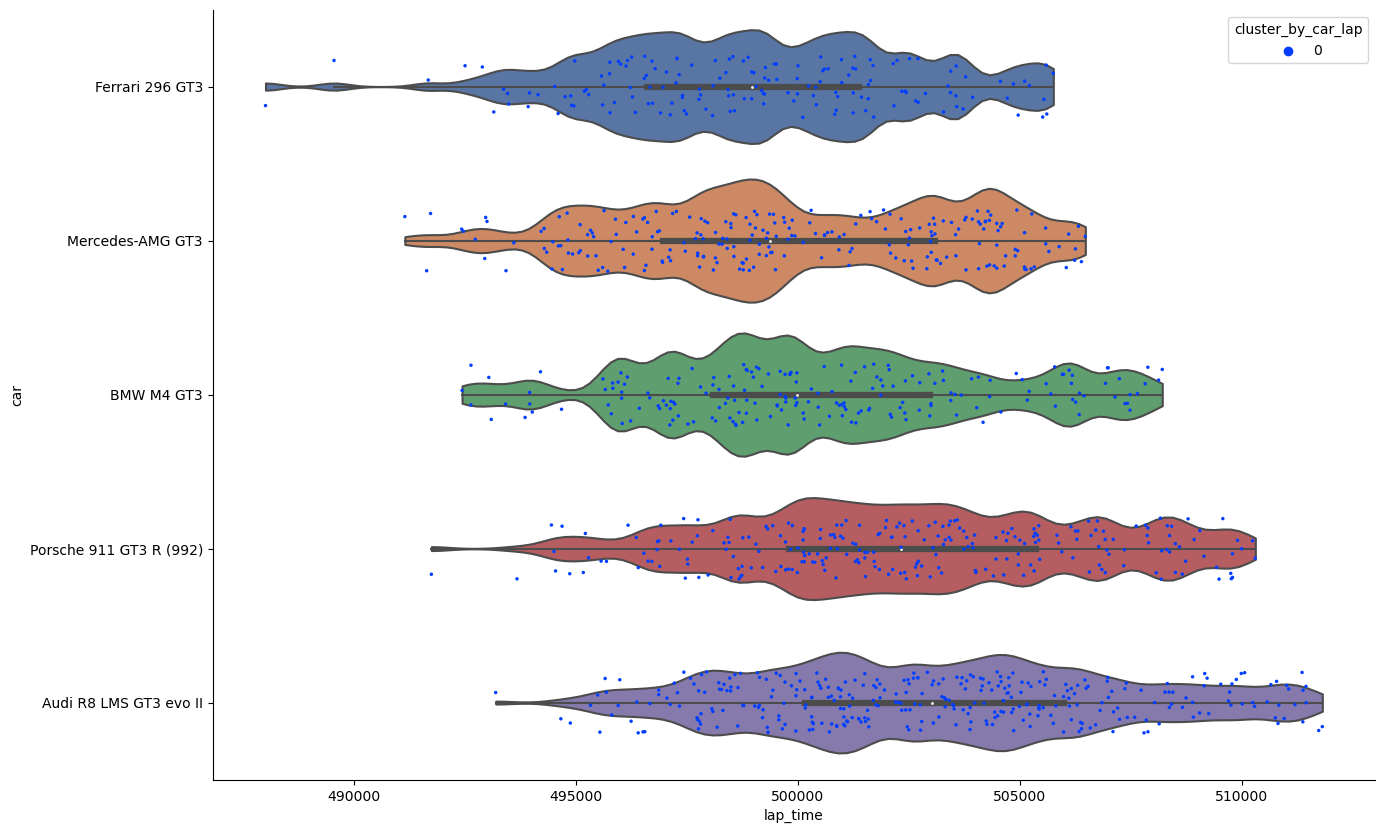

In [15]:
df_sp9_sectors = df_sp9_sectors.query("car != ['Lamborghini Huracan GT3', 'Lamborghini Huracan GT3 EVO2', 'Aston Martin Vantage AMR GT3']")
df_clean_laps = pd.DataFrame(df_sp9_sectors.query("cluster_by_car_lap == 0"))
plot_time_distribution(df_clean_laps, hue="cluster_by_car_lap")

Für den _296 GT3_ zeigt sich eine gute, wenn auch nicht die klar beste Rundenzeitverteilung. Wir vergleichen abschließend die Sektorzeiten in schnellen Runden zwischen Ferraris und anderen Fabrikaten (in Leserichtung, Sektor 1 links oben):

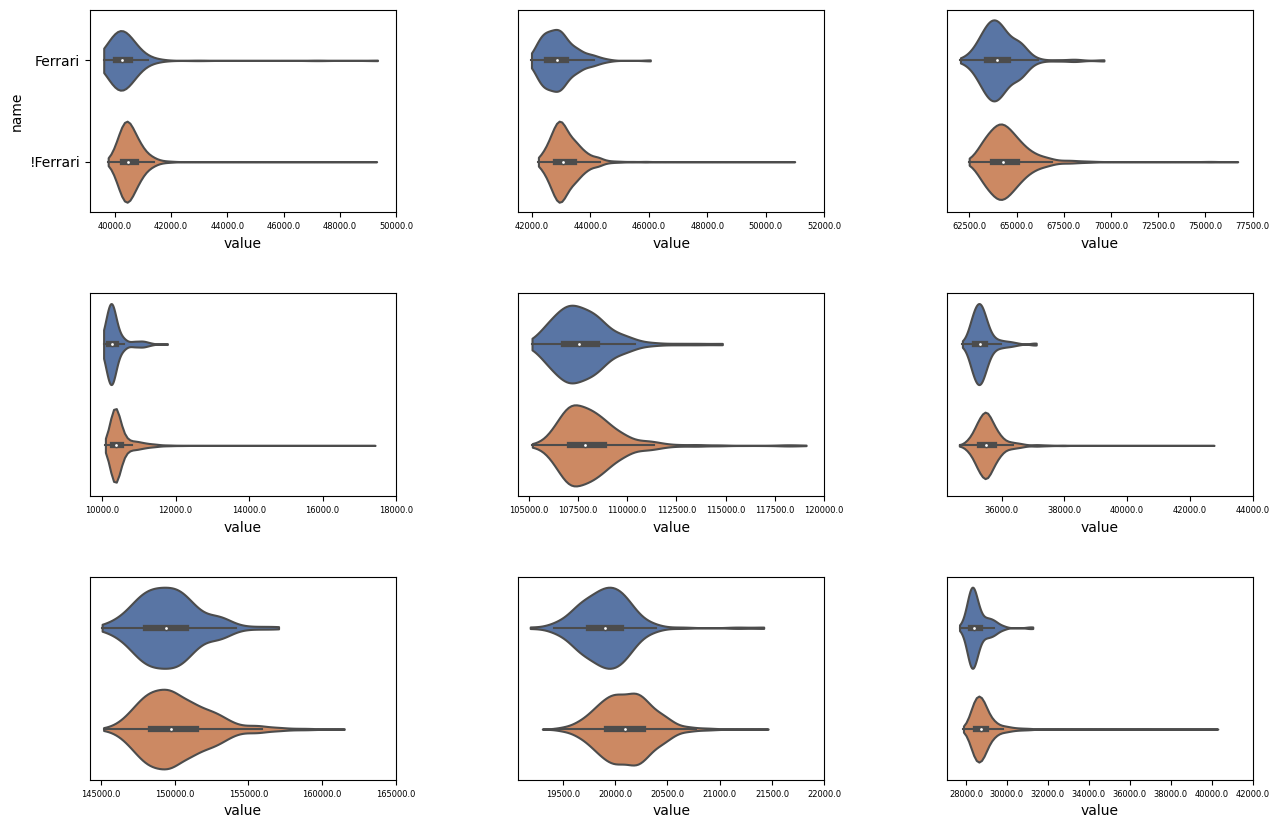

In [16]:
from itertools import chain


def get_sector_times(df: pd.DataFrame) -> pd.DataFrame:
    columns = [[f"sectortime_{i}"] for i in range(1, 10)]
    columns = [*columns, ["lap_time"]]
    columns = list(chain.from_iterable(columns))
    dfst = df.loc[:, columns]
    dfst.columns = pd.MultiIndex.from_tuples(
        [tuple(c.split("_")) for c in dfst.columns]
    )
    return dfst


def plot_sectors(df: pd.DataFrame) -> None:
    df = df.copy()
    
    fig = plt.figure(figsize=(15, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(1, 10):
        df_sub = df.query(f"variable_1 == '{i}'")
        ax = fig.add_subplot(3, 3, i)
        sns.violinplot(
            data=df_sub,
            y="name",
            x="value",
            palette="deep",
            cut=0,
            showfliers=False,
            ax=ax,
        )
        # see https://stackoverflow.com/questions/42404154/increase-tick-label-font-size-in-seaborn
        # prevents: UserWarning: FixedFormatter should only be used together with FixedLocator
        ax.set_xticks(ax.get_xticks()[1:])
        # set the y-labels with
        _ = ax.set_xticklabels(ax.get_xticks(), size=6)

        if i % 9 != 1:
            ax.set(yticklabels=[]) # remove axis info
            ax.set(ylabel=None)  
            ax.tick_params(left=False)
    plt.show()


df_ferrari_sectors = (
    get_sector_times(df_clean_laps.query("car == 'Ferrari 296 GT3'"))
    .melt()
    .query("variable_0 == 'sectortime'")
)
df_ferrari_sectors["is_ferrari"] = True
df_ferrari_sectors["name"] = "Ferrari"
df_unferrari_sectors = (
    get_sector_times(df_clean_laps.query("car != 'Ferrari 296 GT3'"))
    .melt()
    .query("variable_0 == 'sectortime'")
)
df_unferrari_sectors["is_ferrari"] = False
df_unferrari_sectors["name"] = "!Ferrari"

df_all_sectors = pd.concat([df_ferrari_sectors, df_unferrari_sectors])

plot_sectors(df_all_sectors)

Hier zeigt sich ein leichter Vorteil für den _296 GT3_. Insbesondere in den Sektoren _8_ und _9_ macht sich der Unterschied bemerkbar:

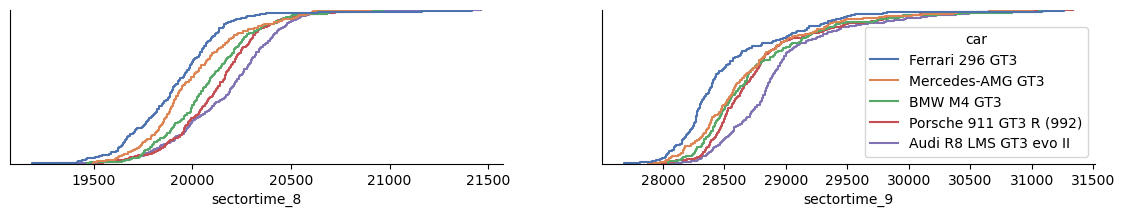

In [17]:
def plot_time_ecdf(df: pd.DataFrame, values: list[str] = ["lap_time"], hue: str | None = None) -> None:
    df = df.copy()
    f, ax = plt.subplots(ncols=len(values), figsize=(14, 2))

    for i, value in enumerate(values):
        df["__sort_q2"] = df.groupby("car")[value].transform(np.quantile, q=0.5)    
        df.sort_values("__sort_q2", inplace=True)
    
        p = sns.ecdfplot(
            hue=df["car"],
            x=df[value],
            palette="deep",
            ax=ax[i],
            legend=False if i==0 else True
        )
        p.set(yticklabels=[])  # remove the tick labels
        p.set(ylabel=None)  # remove the axis label
        p.tick_params(left=False)
    sns.despine()

plot_time_ecdf(df_clean_laps.query("cluster_by_car_lap == 0 and sectortime_9 < 32000"), values=["sectortime_8", "sectortime_9"])

Ein Blick auf die Streckenkarte zeigt, dass die Sektoren _8_ und _9_ zur langen Geraden vor Start und Ziel gehören:

In [18]:
from dataclasses import dataclass


@dataclass
class Coords:
    lat: float
    lon: float


map_center = Coords(
    50.628615,
    6.883192,
)
track_center = Coords(50.35849, 6.95916)

tiles = "CartoDB Dark_Matter" if _DARK_MODE else "CartoDB positron"

nbr_map = folium.Map(
    location=[track_center.lat, track_center.lon],
    zoom_start=13,
    tiles=tiles,
    attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
    scrollWheelZoom=False,
)

folium.Marker(
    [track_center.lat, track_center.lon], popup="Nürburgring track center"
).add_to(nbr_map)

# create a color palette with 9 distinct colors
colors = sns.color_palette("Paired", n_colors=9).as_hex()


def style_function(x: dict) -> dict[str, str]:
    return {"color": colors[int(x["properties"]["name"][-1]) - 1]}


for i in range(9):
    folium.GeoJson(
        f"data/gis/NBR 24h S{i+1}.geojson",
        style_function=style_function,
        tooltip=f"Sektor {i+1}",
    ).add_to(nbr_map)


nbr_map

Ein Rennkommissar könnte angesichts dieser Ergebnisse zu dem Schluss kommen, dass es hinreichende Indizien für einen leichten Vorteil des _296 GT3_  gegenüber den anderen Fahrzeugen gibt, um die Balance of Performance einer erneuten Prüfung zu unterziehen. Ein Renningenieur eines der Ferrari-Teams könnte hingegen auf den Gedanken kommen, seinen Fahrern für das nächste Vorbereitungsrennen oder das nächste Qualifikationstraining etwas weniger Drehzahl auf der langen Geraden zu empfehlen.

### Kritische Würdigung<a class="anchor" id="evaluation-krit"></a>

Ein positiver Aspekt dieses Projekts ist, dass es zeigt, wie nützlich das _CRISP-DM_-Modell für die Arbeit mit großen Datensätzen sein kann. Es ist leicht, sich in den Details und Nebensächlichkeiten solcher Datensätze zu verlaufen.

Auf der anderen Seite war der Aufwand für das Data Wrangling ausgesprochen hoch - ein häufiger Stolperstein in Datenanalyse-Projekten. Die Umwandlung realer Daten in eine für die Analyse geeignete Form erfordert viel Boilerplate-Code und hat hier einen Großteil der Gesamtzeit in Anspruch genommen.

Das verwendete Clustering-Verfahren, GaussianMixture, hat sich als nicht besonders robust erwiesen und benötigte relativ viel manuelles Tuning. Insbesondere war die "richtige" Anzahl von Clustern nicht im Voraus bestimmbar, sondern musste iterativ ermittelt werden. Ein Grid-Search-Ansatz hätte in dieser Situation nützlich sein können, dazu wäre jedoch ein Score nötig gewesen, der die Qualität der Cluster misst, wie zum Beispiel der Silhouette Score [[6]](#shahapure2020).

Schließlich ist zu beachten, dass die Wetterbedingungen während des Rennens 2023 außergewöhnlich konstant waren und es insbesondere immer trocken war. Das wechselhafte Wetter wird in zukünftigen Analysen vorraussichtlich wieder berücksichtigt werden müssen.

### Ausblick<a class="anchor" id="evaluation-ausblick"></a>

In zukünftigen Analysen könnten weitere oder andere Verfahren zur Anomalieerkennung zum Einsatz kommen, um die Ergebnisqualität zu verbessern und weitere Einsichten in die Fahrzeugleistung zu gewähren.

Darüber hinaus könnten mehr Daten in die Analyse einbezogen werden. Dies könnte Daten aus dem Training und dem Qualifying, Daten aus weiteren Rennen und Daten von weiteren Strecken umfassen. 

Auch könnten wir weitere Features in die Analyse einbeziehen, beispielsweise die Streckentemperatur und eine Bewertung der Fahrerleistung (vergleichbar dem ELO-Score aus dem Schach). Diese könnten dazu beitragen, ein umfassenderes Bild der Faktoren zu zeichnen, die die Rundenzeiten beeinflussen.


## Vielen Dank! Fragen?

## Referenzen<a class="anchor" id="referenzen"></a>

[1]<a class="anchor" id="wikipedia2023a"></a> In Wikipedia, „24-Stunden-Rennen auf dem Nürburgring 2023“, Wikipedia, 29. Mai 2023. https://de.wikipedia.org/w/index.php?title=24-Stunden-Rennen_auf_dem_N%C3%BCrburgring_2023&oldid=234125692 (zugegriffen 1. Juni 2023).

[2]<a class="anchor" id="adac2023a"></a> ADAC Nordrhein e.V., „24h-Teilnehmerportal - Bulletins & BoP“, 2023. https://24h-information.de/index.php?id=102&jahr=2023&uid=5565 (zugegriffen 1. Juni 2023).

[3]<a class="anchor" id="adac2023b"></a> ADAC Nordrhein e.V., „24h-Teilnehmerportal - Zeitnahme / Ergebnisse“, 2023. https://24h-information.de/index.php?id=102&jahr=2023&uid=5561 (zugegriffen 1. Juni 2023).


[4]<a class="anchor" id="skl2023a"></a> The scikit-learn developers, „Gaussian mixture models“, scikit-learn, 2023. https://scikit-learn/stable/modules/mixture.html (zugegriffen 1. Juni 2023).

[5]<a class="anchor" id="skl2023b"></a>  The scikit-learn developers, „sklearn.mixture.GaussianMixture“, scikit-learn, 2023. https://scikit-learn/stable/modules/generated/sklearn.mixture.GaussianMixture.html (zugegriffen 1. Juni 2023).

[6]<a class="anchor" id="shahapure2020"></a> K. R. Shahapure und C. Nicholas, „Cluster Quality Analysis Using Silhouette Score“, in 2020 IEEE 7th International Conference on Data Science and Advanced Analytics (DSAA), Sydney, Australia: IEEE, Okt. 2020, S. 747–748. doi: 10.1109/DSAA49011.2020.00096.


[7]<a class="anchor" id="Barron_Suncalcpy_2023"></a> K. Barron, „suncalc-py“. 5. Mai 2023. Zugegriffen: 1. Juni 2023. [Online]. Verfügbar unter: https://github.com/kylebarron/suncalc-py

[8]<a class="anchor" id="EuropeanCommission_Regulation9232012_2012"></a> European Commission, „Regulation 923/2012“. 26. September 2012. [Online]. Verfügbar unter: https://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32012R0923

[9]<a class="anchor" id="DeutscherWetterdienst_ClimateData_2023"></a> Deutscher Wetterdienst, „Climate Data Center“, 2023. https://cdc.dwd.de/portal/shortlink/b0076c6a-0617-4c11-94bd-ff059cafd543 (zugegriffen 1. Juni 2023).

[10]<a class="anchor" id="ThePandasDevelopmentTeam_Pandasmergeasof_2023"></a> The pandas development team, „pandas.merge_asof — pandas 2.0.2 documentation“, 2023. https://pandas.pydata.org/docs/reference/api/pandas.merge_asof.html (zugegriffen 1. Juni 2023).

## Backup

In [19]:
df_race_sectors.groupby("car_number").min().sort_values("theoretical_best_time").loc[:, ["team", "car", "time_of_day", "theoretical_best_time"]].head(10)

,team,car,time_of_day,theoretical_best_time
car_number,,,,
20,WTM by Rinaldi Racing,Ferrari 296 GT3,00:02:03.432,485552
30,Frikadelli Racing Team,Ferrari 296 GT3,00:08:13.926,486623
4,Mercedes-AMG Team Bilstein,Mercedes-AMG GT3,00:02:24.700,487109
98,ROWE RACING,BMW M4 GT3,00:01:12.252,487212
2,Mercedes-AMG Team GetSpeed,Mercedes-AMG GT3,00:10:28.985,487900
27,ABT Sportsline,Lamborghini Huracan GT3 EVO2,00:05:33.990,488351
911,Manthey EMA,Porsche 911 GT3 R (992),00:07:58.487,489081
99,ROWE RACING,BMW M4 GT3,00:11:00.028,489356
72,BMW Junior Team,BMW M4 GT3,00:10:38.355,490034


### Sonnenstand

Um Einflüsse durch den Sonnenstand, insbesondere durch Blendung bewerten zu können, bestimmen den Azimut und die Höhe der Sonne für jede Runde mit dem suncalc-Paket von Kyle Barron [[7]](#Barron_Suncalcpy_2023)-Paket von Kyle Barron. Wir berechnen die Position der Sonne relativ zu einem willkürlich gewählten Punkt nahe dem Zentrum der Strecke (50°21'30.6"N 6°57'33.0"E) zum Zeitpunkt jeder abgeschlossenen Runde. Wir verwenden dazu nicht den Wert `time_of_day`, da dieser kein Datum enthält und wir den Übergang vom Samstag zum Sonntag gesondert behandeln müssten. Besser eignet sich der `time_elapsed`-Wert - die seit dem 20.05.2023 um 00:00:00+02:00 zum Abschluss jeder Runde verstrichene Zeit in Millisekunden:


In [20]:
import math

elapsed_zero = pd.Timestamp("2023-05-20 00:00:00", tz="Europe/Berlin").tz_convert("utc")
df_sp9_sectors["lap_timestamp"] = elapsed_zero + df_sp9_sectors[
    "elapsed_time"
].astype("timedelta64[ms]")

solar_positions = pd.DataFrame(
    suncalc.get_position(
        df_sp9_sectors["lap_timestamp"], track_center.lon, track_center.lat
    )
)

df_sp9_sectors = pd.concat([df_sp9_sectors, solar_positions], axis=1)


Mit der Ermittlung der Sonnenhöhe für jede Runde sind wir nun in der Lage, die Runden zu unterscheiden, die während der Nachtstunden absolviert wurden. Gemäß der zivilen Dämmerungsgrenze nach der Definition der [European Union Aviation Safety Agency (EASA)](http://www.easa.europa.eu/) betrachten wir eine Runde als "unter dunklen Bedingungen" durchgeführt, wenn die Sonnenhöhe unter -6° liegt [[8]](#EuropeanCommission_Regulation9232012_2012). Suncalc gibt die Sonnenhöhe in Radianten zurück, daher müssen wir den Schwellenwert umrechnen: $-\frac{6}{180}\pi \approx -0,10472$

In [21]:

night_threshold = -6 / 180 * math.pi
df_sp9_sectors["night"] = df_sp9_sectors["altitude"] < (night_threshold)

glare_lower_threshold = -1 / 180 * math.pi
glare_upper_threshold = 15 / 180 * math.pi
df_sp9_sectors["glare"] = df_sp9_sectors["altitude"].apply(
    lambda x: glare_lower_threshold < x < glare_upper_threshold
)

df_sp9_sectors.sample(5).loc[:, ["lap_timestamp", "night", "glare"]]

,,lap_timestamp,night,glare
car_number,lap_number,,,
911,20,2023-05-20 17:07:56.994000+00:00,False,False
96,67,2023-05-20 23:59:09.498000+00:00,True,False
20,136,2023-05-21 10:26:44.323000+00:00,False,False
101,18,2023-05-20 16:37:56.663000+00:00,False,False
33,54,2023-05-20 22:04:50.452000+00:00,True,False



### Wetter

Wir fügen Wetterdaten hinzu, um die Rundenzeiten in Abhängigkeit von den Wetterbedingungen analysieren zu können. Wir beziehen die Wetterdaten vom [Deutschen Wetterdienst (DWD)](https://www.dwd.de/EN/Home/home_node.html), der aktuelle und historische Stationsdaten im CSV-Format zur Verfügung stellt. Wir nutzen die Lufttemperatur in 2 Metern Höhe (OBS_DEU_PT10M_T2M) und den Luftdruck auf Stationsniveau (OBS_DEU_PT10M_PP), die an der Station Nürburg-Barweiler in 10-Minuten-Intervallen gemessen wurden (etwa 6,34 km vom Referenzpunkt entfernt) [[9]](#DeutscherWetterdienst_ClimateData_2023).

Spaßiges Problem: Die CSV des DWD haben ein zusätzliches abschließendes Trennzeichen pro Zeile, was dazu führt, dass der Pandas-CSV-Parser die erste Spalte als Zeilenindex des DataFrames behandelt und die restlichen Daten sich ein Feld nach links schieben. Um dies zu beheben, übergeben wir `index_col=False` an `pd.read_csv()`.

Wir stellen sicher, dass die Zeitstempel auf die gleiche Zeitzone wie die Rundenzeiten gesetzt sind und indizieren die Wetterdaten nach Zeitstempel, um das Zusammenführen zu erleichtern. 


In [22]:
def read_weather_data(filename: str) -> pd.DataFrame:
    weather_data = pd.read_csv(
        filename,
        sep=",",
        index_col=False,
        usecols=["Zeitstempel", "Wert"],
        # parse_dates=["Zeitstempel"],
    )
    weather_data["Zeitstempel"] = pd.to_datetime(weather_data["Zeitstempel"], utc=True)
    weather_data.set_index("Zeitstempel", inplace=True)
    return weather_data

air_temp_df = read_weather_data("data/weather/data_OBS_DEU_PT10M_T2M_3660.csv")
air_temp_df.rename(columns={"Wert": "air_temperature"}, inplace=True)
air_pressure_df = read_weather_data("data/weather/data_OBS_DEU_PT10M_PP_3660.csv")
air_pressure_df.rename(columns={"Wert": "air_pressure"}, inplace=True)

atm_df = pd.merge(
    air_temp_df,
    air_pressure_df,
    left_index=True,
    right_index=True,
)

atm_df.sample(5)

,air_temperature,air_pressure
Zeitstempel,,
2023-05-21 06:00:00+00:00,10.5,958.7
2023-05-21 19:00:00+00:00,18.0,958.1
2023-05-21 00:30:00+00:00,10.2,959.4
2023-05-20 13:40:00+00:00,16.0,961.0
2023-05-22 00:00:00+00:00,14.8,958.0


Wir verknüpfen nun die gesammelten Wetterdaten mit unseren Rundenzeiten. Da die Zeitstempel der Wettermessungen nicht mit den Durchgangszeiten synchronisiert sind, führen wir einen __Merge nach Schlüsseldistanz__ [[10]](#ThePandasDevelopmentTeam_Pandasmergeasof_2023) durch und fügen jeder Runde den zeitlich nächsten Messwert hinzu:

In [23]:
# Both dataframes must be sorted by timestamp
df_sp9_sectors.sort_values(by="lap_timestamp", inplace=True)
atm_df.sort_index(inplace=True)

df_sp9_sectors = pd.merge_asof(
    df_sp9_sectors,
    atm_df,
    left_on="lap_timestamp",
    right_index=True,
    direction="nearest",
)

df_sp9_sectors.sample(5).loc[:, ["lap_timestamp", "air_temperature", "air_pressure"]]

,,lap_timestamp,air_temperature,air_pressure
car_number,lap_number,,,
44,116,2023-05-21 07:26:02.812000+00:00,13.2,958.9
40,144,2023-05-21 11:50:40.117000+00:00,19.9,958.0
101,13,2023-05-20 15:52:46.590000+00:00,15.8,960.6
96,9,2023-05-20 15:18:41.684000+00:00,16.2,960.6
33,4,2023-05-20 14:33:51.480000+00:00,16.4,960.6


Wir vergleichen die Rundenzeiten unter Blendbedingungen und ohne Blendbedingungen:

<Axes: xlabel='lap_time', ylabel='car'>

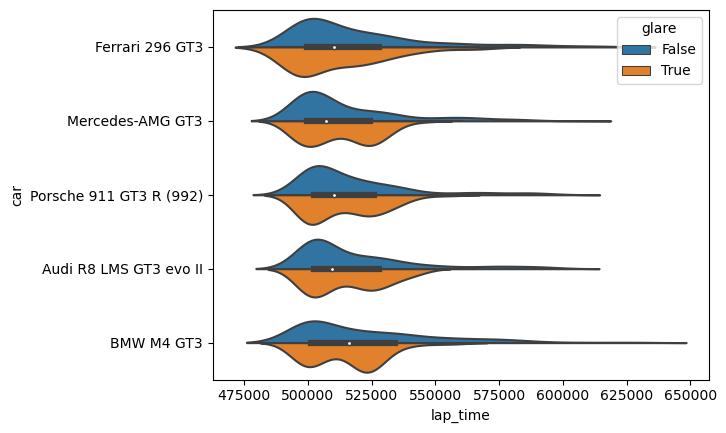

In [24]:
sns.violinplot(data=df_sp9_sectors, y="car", x="lap_time", hue="glare", split=True, showfliers=False)

Und wir stellen den gleichen Vergleich für die Rundenzeiten unter Tages- und Nachtbedingungen an:

<Axes: xlabel='lap_time', ylabel='car'>

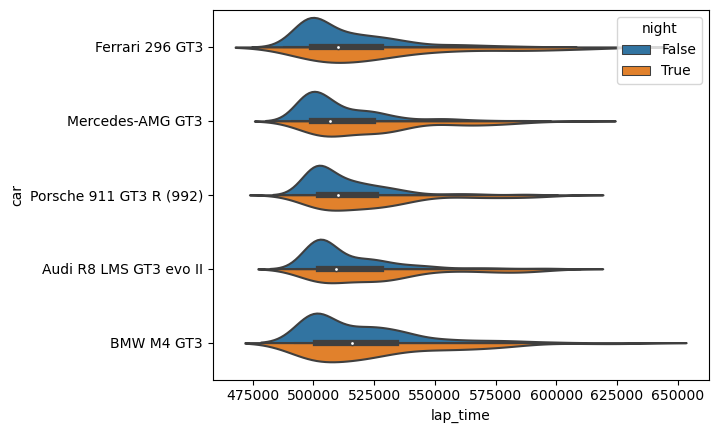

In [25]:
sns.violinplot(data=df_sp9_sectors, y="car", x="lap_time", hue="night", split=True, showfliers=False)